In [13]:
import pandas as pd

In [14]:
import glob

# Find all .jsonl files in the current directory
jsonl_files = glob.glob("*.jsonl")

# Read and concatenate all jsonl files into a single DataFrame
df = pd.concat([pd.read_json(f, lines=True) for f in jsonl_files], ignore_index=True)
df = df.rename(columns={'instruction':'question', 'input':'context', 'output':'response'})
df = df.drop(columns=["id"]).drop_duplicates(subset="question")
df.shape

(1603, 3)

## Remove null values

In [15]:
df["question"]   = df["question"].str.replace("[deleted]", "", regex=False)
df["question"]   = df["question"].str.replace("[removed]", "", regex=False)
df["context"]         = df["context"].str.replace("[removed]", "", regex=False)
df["context"]         = df["context"].str.replace("[deleted]", "", regex=False)
df["response"]        = df["response"].str.replace("[deleted]", "", regex=False)
df["response"]        = df["response"].str.replace("[removed]", "", regex=False)

print("Before:",df.shape)
df = df[(df["question"].str.strip() != "") & (df["context"].str.strip() != "") & (df["response"].str.strip() != "")]
print("After:",df.shape)

Before: (1603, 3)
After: (1486, 3)


## Token distribution analysis

In [16]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def get_token_count(column, tokenizer):
    return column.apply(lambda x: len(tokenizer.tokenize(str(x))))

question_token_counts = get_token_count(df["question"],tokenizer)
context_token_counts = get_token_count(df["context"], tokenizer)
response_token_counts = get_token_count(df["response"], tokenizer)

print(question_token_counts.describe())
print(context_token_counts.describe())
print(response_token_counts.describe())

Token indices sequence length is longer than the specified maximum sequence length for this model (652 > 512). Running this sequence through the model will result in indexing errors


count    1486.000000
mean       14.558546
std         9.741107
min         1.000000
25%         9.000000
50%        12.000000
75%        17.000000
max        74.000000
Name: question, dtype: float64
count    1486.000000
mean      222.353297
std       503.812841
min         1.000000
25%        60.000000
50%       117.000000
75%       220.000000
max      9427.000000
Name: context, dtype: float64
count    1486.000000
mean      116.775236
std       172.325584
min         1.000000
25%        27.000000
50%        60.000000
75%       139.750000
max      2155.000000
Name: response, dtype: float64


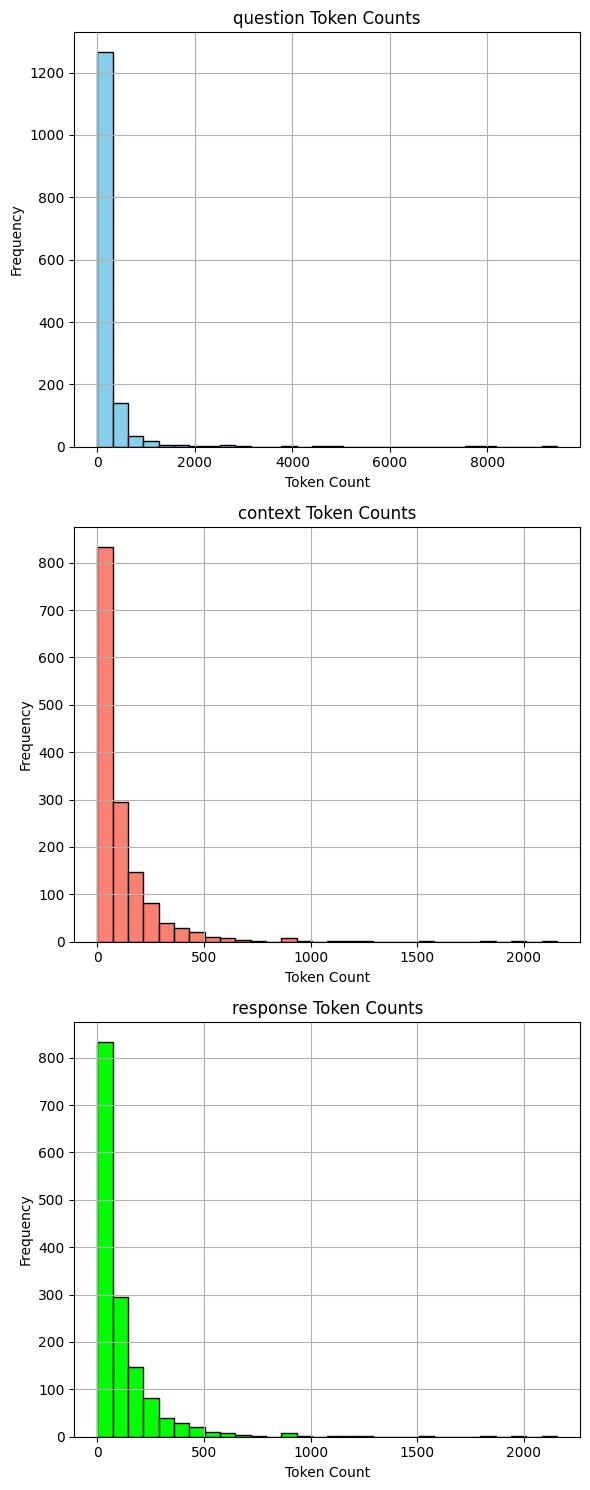

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 15))

plt.subplot(3, 1, 1)
context_token_counts.hist(bins=30, color='skyblue', edgecolor='black')
plt.title('question Token Counts')
plt.xlabel('Token Count')
plt.ylabel('Frequency')

plt.subplot(3, 1, 2)
response_token_counts.hist(bins=30, color='salmon', edgecolor='black')
plt.title('context Token Counts')
plt.xlabel('Token Count')
plt.ylabel('Frequency')

plt.subplot(3, 1, 3)
response_token_counts.hist(bins=30, color='lime', edgecolor='black')
plt.title('response Token Counts')
plt.xlabel('Token Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Trim the data by token count
The maximum token count for `question` + `context` + `response` is at maximum **2048** for TinyLlama.

Since we will be training the model with Unsloth, which added support for **RoPA Scaling**, the proclaimed token length is increased up to **4096**.

In [20]:
lower_bound, upper_bound = 5, 1536

mask = (
    (question_token_counts >= lower_bound) & (question_token_counts <= upper_bound) &
    (context_token_counts >= lower_bound) & (context_token_counts <= upper_bound) &
    (response_token_counts >= lower_bound) & (response_token_counts <= upper_bound)
)

df_trimmed = df[mask].reset_index(drop=True)

for col in df_trimmed.columns:
    print(get_token_count(df_trimmed[col], tokenizer).describe())

count    1364.000000
mean       14.751466
std         9.365519
min         5.000000
25%         9.000000
50%        12.000000
75%        18.000000
max        74.000000
Name: question, dtype: float64
count    1364.000000
mean      182.293988
std       202.553362
min         5.000000
25%        62.000000
50%       119.000000
75%       219.000000
max      1510.000000
Name: context, dtype: float64
count    1364.000000
mean      114.935484
std       148.375291
min         5.000000
25%        29.000000
50%        63.000000
75%       142.000000
max      1530.000000
Name: response, dtype: float64


In [19]:
df_trimmed.to_csv("reddit_linux_qna_data.csv", index=False)